In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import utlis

import lightgbm as lgb

In [3]:
# Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/Predicting City-Scale Daily Electricity Use and Daily Peak Demand'
sys.path.insert(0,PATH_TO_ROOT)

In [4]:
def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section4.3 covid/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

In [5]:
# set up the hyper-parameter
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
# params['sub_feature'] = 0.5
params['num_leaves'] = 4
params['min_data_in_leaf'] = 30
params['max_depth'] = 5

title = {'la': 'Los Angeles', 'sac':'Sacramento', 'ny':'New York'}
regions = ['la','sac','ny']

result_all = {}

In [6]:
for index in range(3):
    region = regions[index]

    data = pd.read_csv(generate_input_data_path(f'{region}_daily'), index_col=0)
    data.index = pd.to_datetime(data.index)

    data_lgmb = data[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'Weekend',
                      'Electricity demand, daily sum, (GWh)']].copy()
    data_lgmb['Month'] = data_lgmb.index.month
    data_lgmb['dayOfWeek'] = data_lgmb.index.weekday
    data_lgmb = data_lgmb.dropna()

    # train the model
    data_train, data_test = utlis.prepare_data(data_lgmb, train_ratio=0.9)
    X_train = data_train[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'dayOfWeek', 'Month']].values
    X_test = data_test[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'dayOfWeek', 'Month']].values
    y_train = data_train['Electricity demand, daily sum, (GWh)'].values
    y_test = data_test['Electricity demand, daily sum, (GWh)'].values
    d_train = lgb.Dataset(X_train, categorical_feature=[2,3,4], label=y_train)
    clf = lgb.train(params, d_train, 5000)

    # make prediction
    X_all = data_lgmb[['Temperature, daily mean (degC)', 'Temperature, daily peak (degC)', 'Holiday', 'dayOfWeek', 'Month']].values
    data_lgmb['yhat_lgbm'] = clf.predict(X_all)
    data_lgmb.index = data_lgmb['ds']

    result = data_lgmb[['Electricity demand, daily sum, (GWh)','yhat_lgbm']].copy()
    result.rename(columns={'Electricity demand, daily sum, (GWh)':'y',
                               'yhat_lgbm':'yhat'}, inplace=True)
    result['train'] = False
    result.loc[data_train.ds, 'train'] = True
    
    result_all[region] = result

C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344
[LightGBM] [Info] Number of data points in the train set: 1719, number of used features: 5
[LightGBM] [Info] Start training from score 77.384470


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 1721, number of used features: 5
[LightGBM] [Info] Start training from score 47.884213


C:\Users\walter\Anaconda3\envs\cityElePaper\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 1721, number of used features: 5
[LightGBM] [Info] Start training from score 434.555225


In [7]:
cities = ['Los Angeles', 'Sacramento', 'New York']

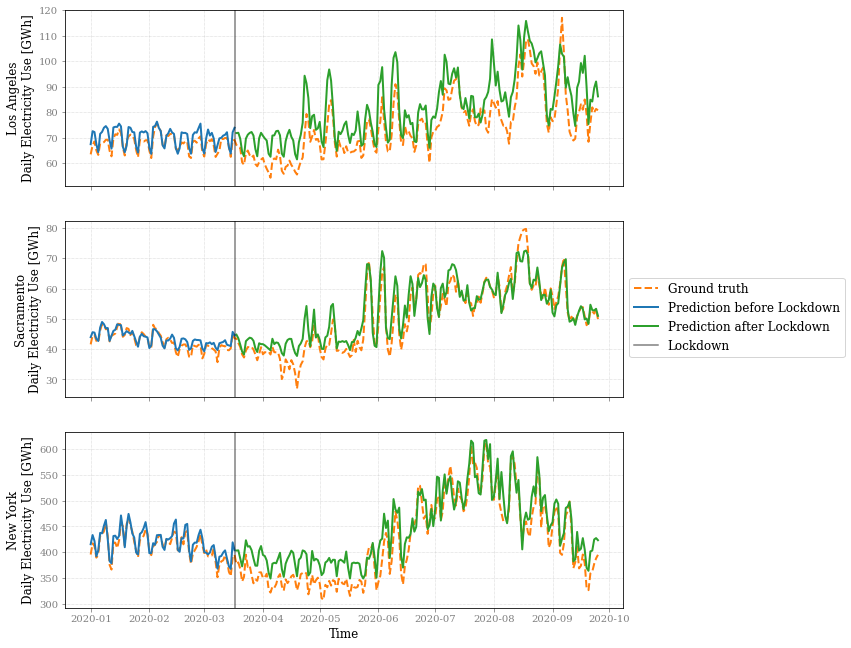

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True)
monthly_all = {}

for index in range(3):
    region = regions[index]
    data = result_all[region]
    city = cities[index]
    
    verif = data.truncate(before='2020-01-01')

    axes[index].plot(verif.index, verif.y, color=default_colors[1], linestyle='--', lw=2, label='Ground truth')
    train = verif[verif['train']]
    axes[index].plot(train.index, train.yhat, color=default_colors[0], lw=2, label='Prediction before Lockdown')
    test = verif[verif['train'] == False]
    axes[index].plot(test.index, test.yhat, color=default_colors[2], lw=2, label='Prediction after Lockdown')
    axes[index].axvline(verif[verif['train']].index[-1], color='black', alpha=0.5, label = 'Lockdown')

    axes[index].set_ylabel(f'{city}\nDaily Electricity Use [GWh]')
    axes[index].grid(ls=':', lw=0.5)
    
    # summary of monthly reduction
    verif['month'] = verif.index.month
    monthly = verif.groupby('month').sum()
    monthly['percent'] = monthly['y']/monthly['yhat']
    monthly_all[region] = monthly.percent.values

axes[2].legend(loc='center left', bbox_to_anchor=(1,1.65))
axes[2].set_xlabel('Time')

plt.savefig(generate_fig_path('Figure 17'))

In [9]:
import matplotlib.ticker as mtick

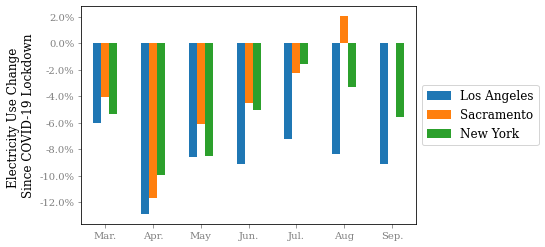

In [10]:
monthly_all_df = pd.DataFrame(monthly_all)-1
monthly_all_df.columns = cities
monthly_covid = monthly_all_df.iloc[2:,:]
monthly_covid.index = ['Mar.', 'Apr.', 'May', 'Jun.', 'Jul.', 'Aug', 'Sep.']

ax = monthly_covid.plot.bar(rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel('Electricity Use Change \nSince COVID-19 Lockdown')
plt.savefig(generate_fig_path('Figure 18'))